In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

- Load the model and the processor

In [2]:
from transformers import BlipForImageTextRetrieval

In [3]:
model = BlipForImageTextRetrieval.from_pretrained(
    "Salesforce/blip-itm-base-coco")

More info about [Salesforce/blip-itm-base-coco](https://huggingface.co/Salesforce/blip-itm-base-coco).

In [4]:
from transformers import AutoProcessor

In [5]:
processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-itm-base-coco")

In [6]:
print(model)

BlipForImageTextRetrieval(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, 

In [7]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'

In [8]:
from PIL import Image
import requests

In [9]:
raw_image =  Image.open(
    requests.get(img_url, stream=True).raw).convert('RGB')

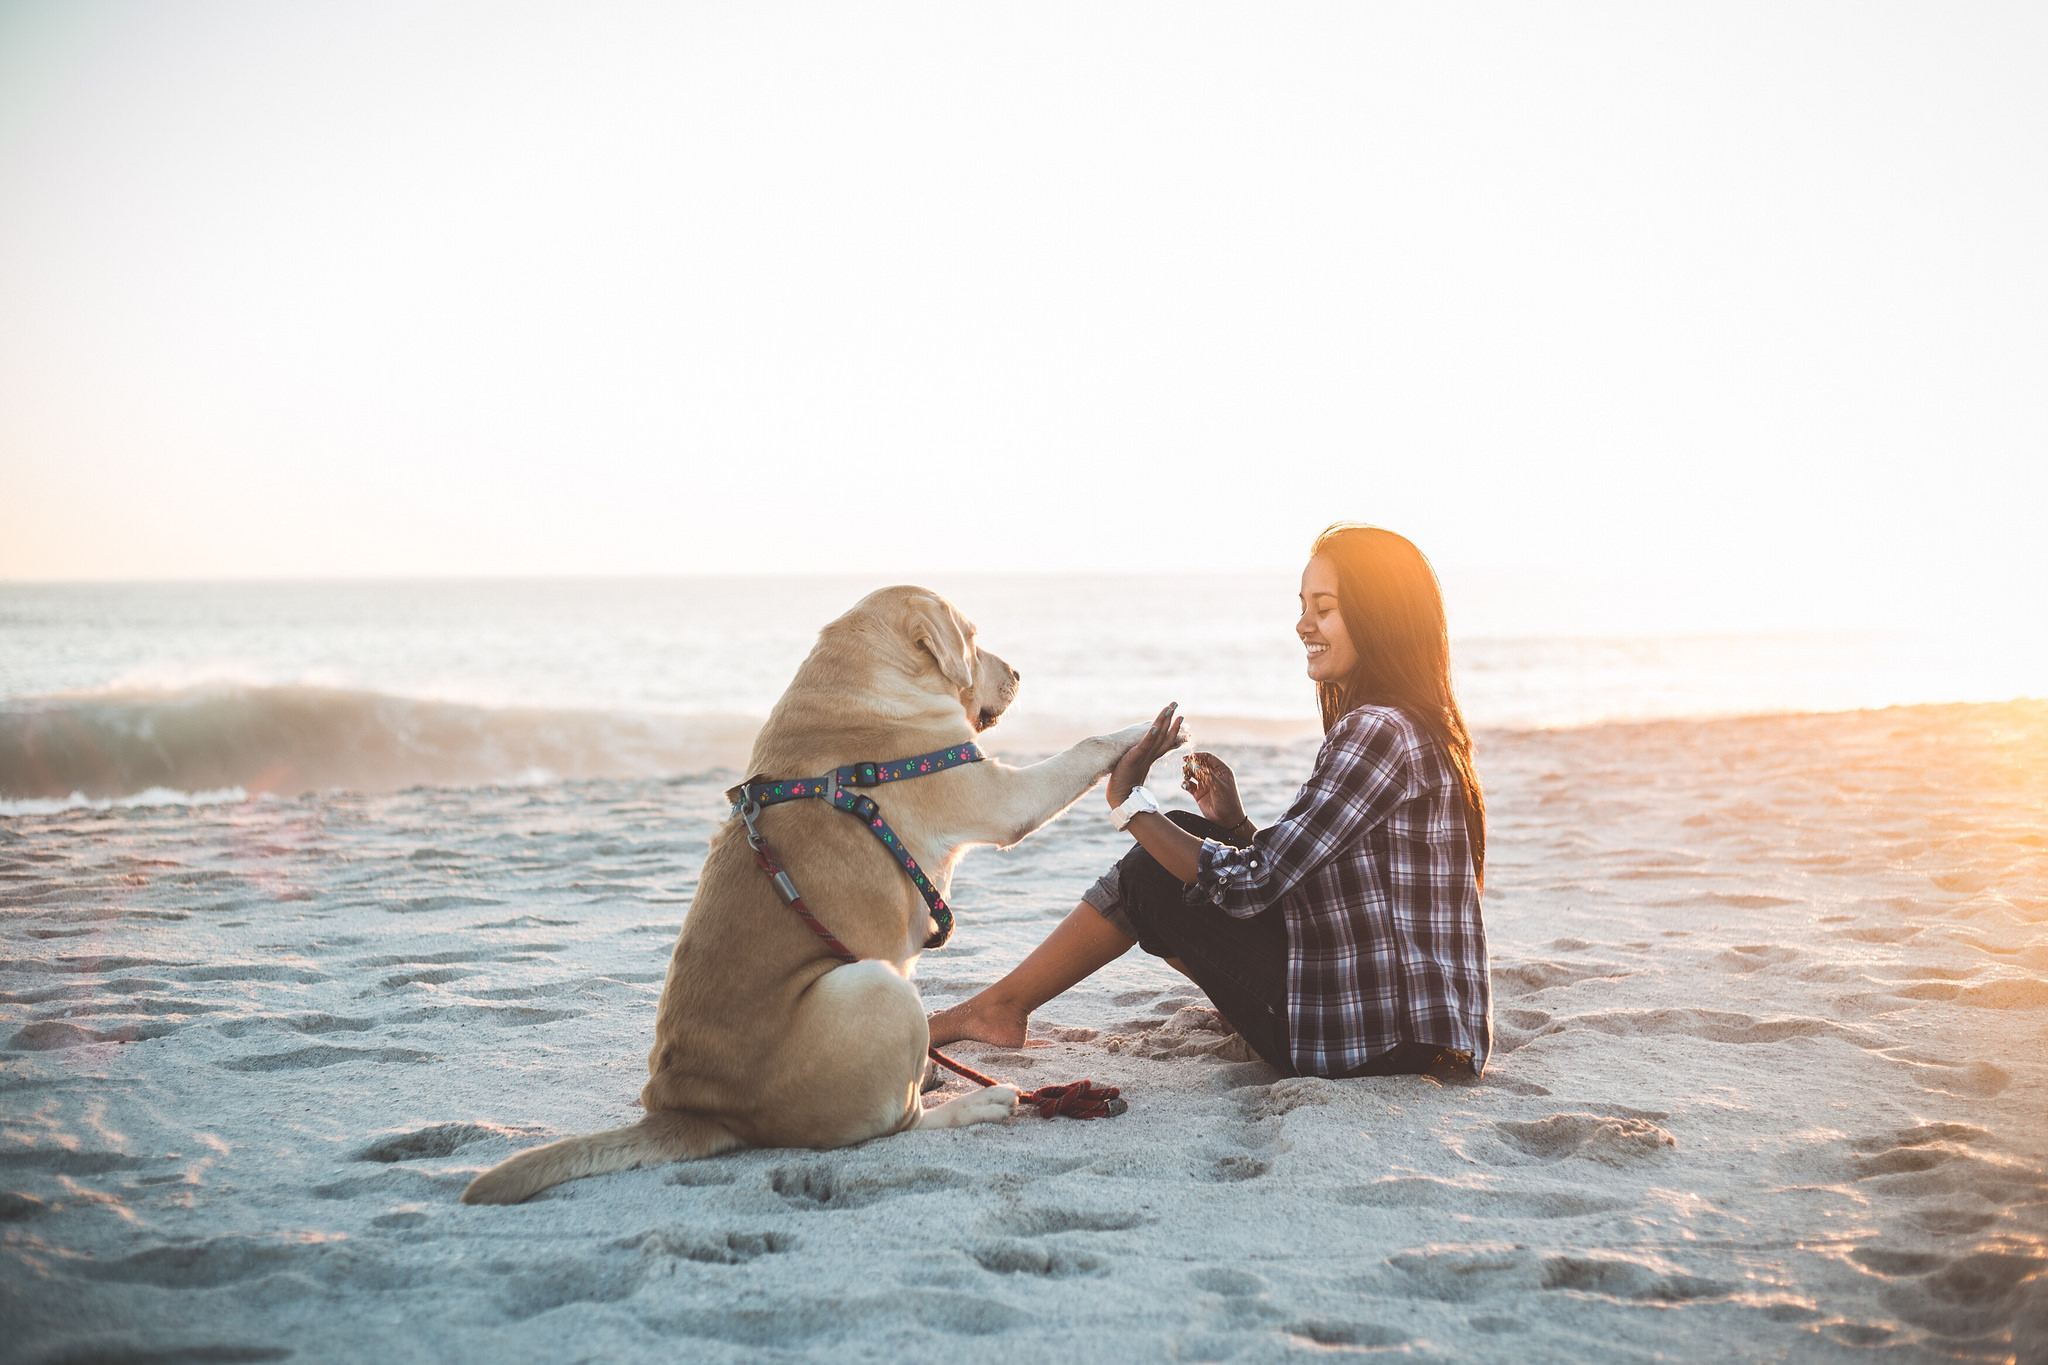

In [10]:
raw_image

### Test, if the image matches the text

In [11]:
text = "an image of a woman and a dog on the beach"

In [12]:
inputs = processor(images=raw_image,
                   text=text,
                   return_tensors="pt")

In [13]:
inputs

{'pixel_values': tensor([[[[ 0.8647,  0.9230,  0.9376,  ...,  1.7552,  1.7552,  1.7552],
          [ 0.9084,  0.9376,  0.9522,  ...,  1.7552,  1.7552,  1.7552],
          [ 0.9376,  0.9376,  0.9668,  ...,  1.7552,  1.7552,  1.7552],
          ...,
          [-0.7850, -0.7850, -0.7266,  ..., -0.3178, -0.2740, -0.3616],
          [-0.7558, -0.7558, -0.7412,  ..., -0.3178, -0.3616, -0.4346],
          [-0.7558, -0.7704, -0.7850,  ..., -0.3616, -0.4346, -0.4784]],

         [[ 1.2194,  1.2495,  1.2795,  ...,  1.8948,  1.8948,  1.8948],
          [ 1.2344,  1.2645,  1.2945,  ...,  1.8948,  1.8948,  1.8948],
          [ 1.2495,  1.2795,  1.3095,  ...,  1.8948,  1.8948,  1.8948],
          ...,
          [-0.5965, -0.5965, -0.5515,  ..., -0.4014, -0.3264, -0.4164],
          [-0.5665, -0.5665, -0.5515,  ..., -0.3864, -0.4164, -0.4914],
          [-0.5665, -0.5815, -0.5965,  ..., -0.4164, -0.4764, -0.5365]],

         [[ 1.2927,  1.3211,  1.3496,  ...,  1.9753,  1.9753,  1.9753],
          [ 1

In [14]:
itm_scores = model(**inputs)[0]

In [15]:
itm_scores

tensor([[-2.2228,  2.2260]], grad_fn=<AddmmBackward0>)

In [16]:
import torch

- Use a softmax layer to get the probabilities

In [17]:
itm_score = torch.nn.functional.softmax(
    itm_scores,dim=1)

In [18]:
itm_score

tensor([[0.0116, 0.9884]], grad_fn=<SoftmaxBackward0>)

In [19]:
print(f"""\
The image and text are matched \
with a probability of {itm_score[0][1]:.4f}""")

The image and text are matched with a probability of 0.9884


### Search for images on your on machine

In [20]:
import os
import torch
from PIL import Image

def process_images_and_get_highest_score(directory, text, processor, model, device="cuda"):
    """
    Process all .png images in a directory and return the highest score and corresponding image.

    Args:
        directory (str): Path to the directory containing .png images.
        text (str): Text input to be used with the processor.
        processor: A preprocessing object with a method for handling images and text.
        model: A model that processes the outputs of the processor.
        device (str): The device to use for computation ("cuda" or "cpu").

    Returns:
        tuple: The highest score and the corresponding PIL image.
    """
    highest_score = 0.0  # Initialize the highest score
    theimg = None        # To store the image with the highest score

    # Move the model to the specified device
    model = model.to(device)

    # Iterate over all .png files in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith(".png"):
            file_path = os.path.join(directory, file_name)

            # Open the image as a PIL image
            current_img = Image.open(file_path).convert("RGB")  # Ensure it's in RGB mode

            # Process the current image
            inputs = processor(images=current_img, text=text, return_tensors="pt").to(device)  # Move inputs to GPU
            itm_scores = model(**inputs)[0]  # Forward pass
            itm_score = torch.nn.functional.softmax(itm_scores, dim=1)

            # Get the score for the 'positive' class (assuming index 1 is positive)
            max_score = itm_score[0][1].item()

            # Update the highest score if necessary
            if max_score > highest_score:
                highest_score = max_score
                theimg = current_img

    return highest_score, theimg


In [21]:
directory = r"C:\Users\pc\Pictures\Screenshots" #replace with folder filled with images to search into
text = "green monster" #write the closest description you remember of the image 

# Ensure CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"

highest_score, theimg = process_images_and_get_highest_score(directory, text, processor, model, device=device)
print("Highest Score:", highest_score)


Highest Score: 0.3171563446521759


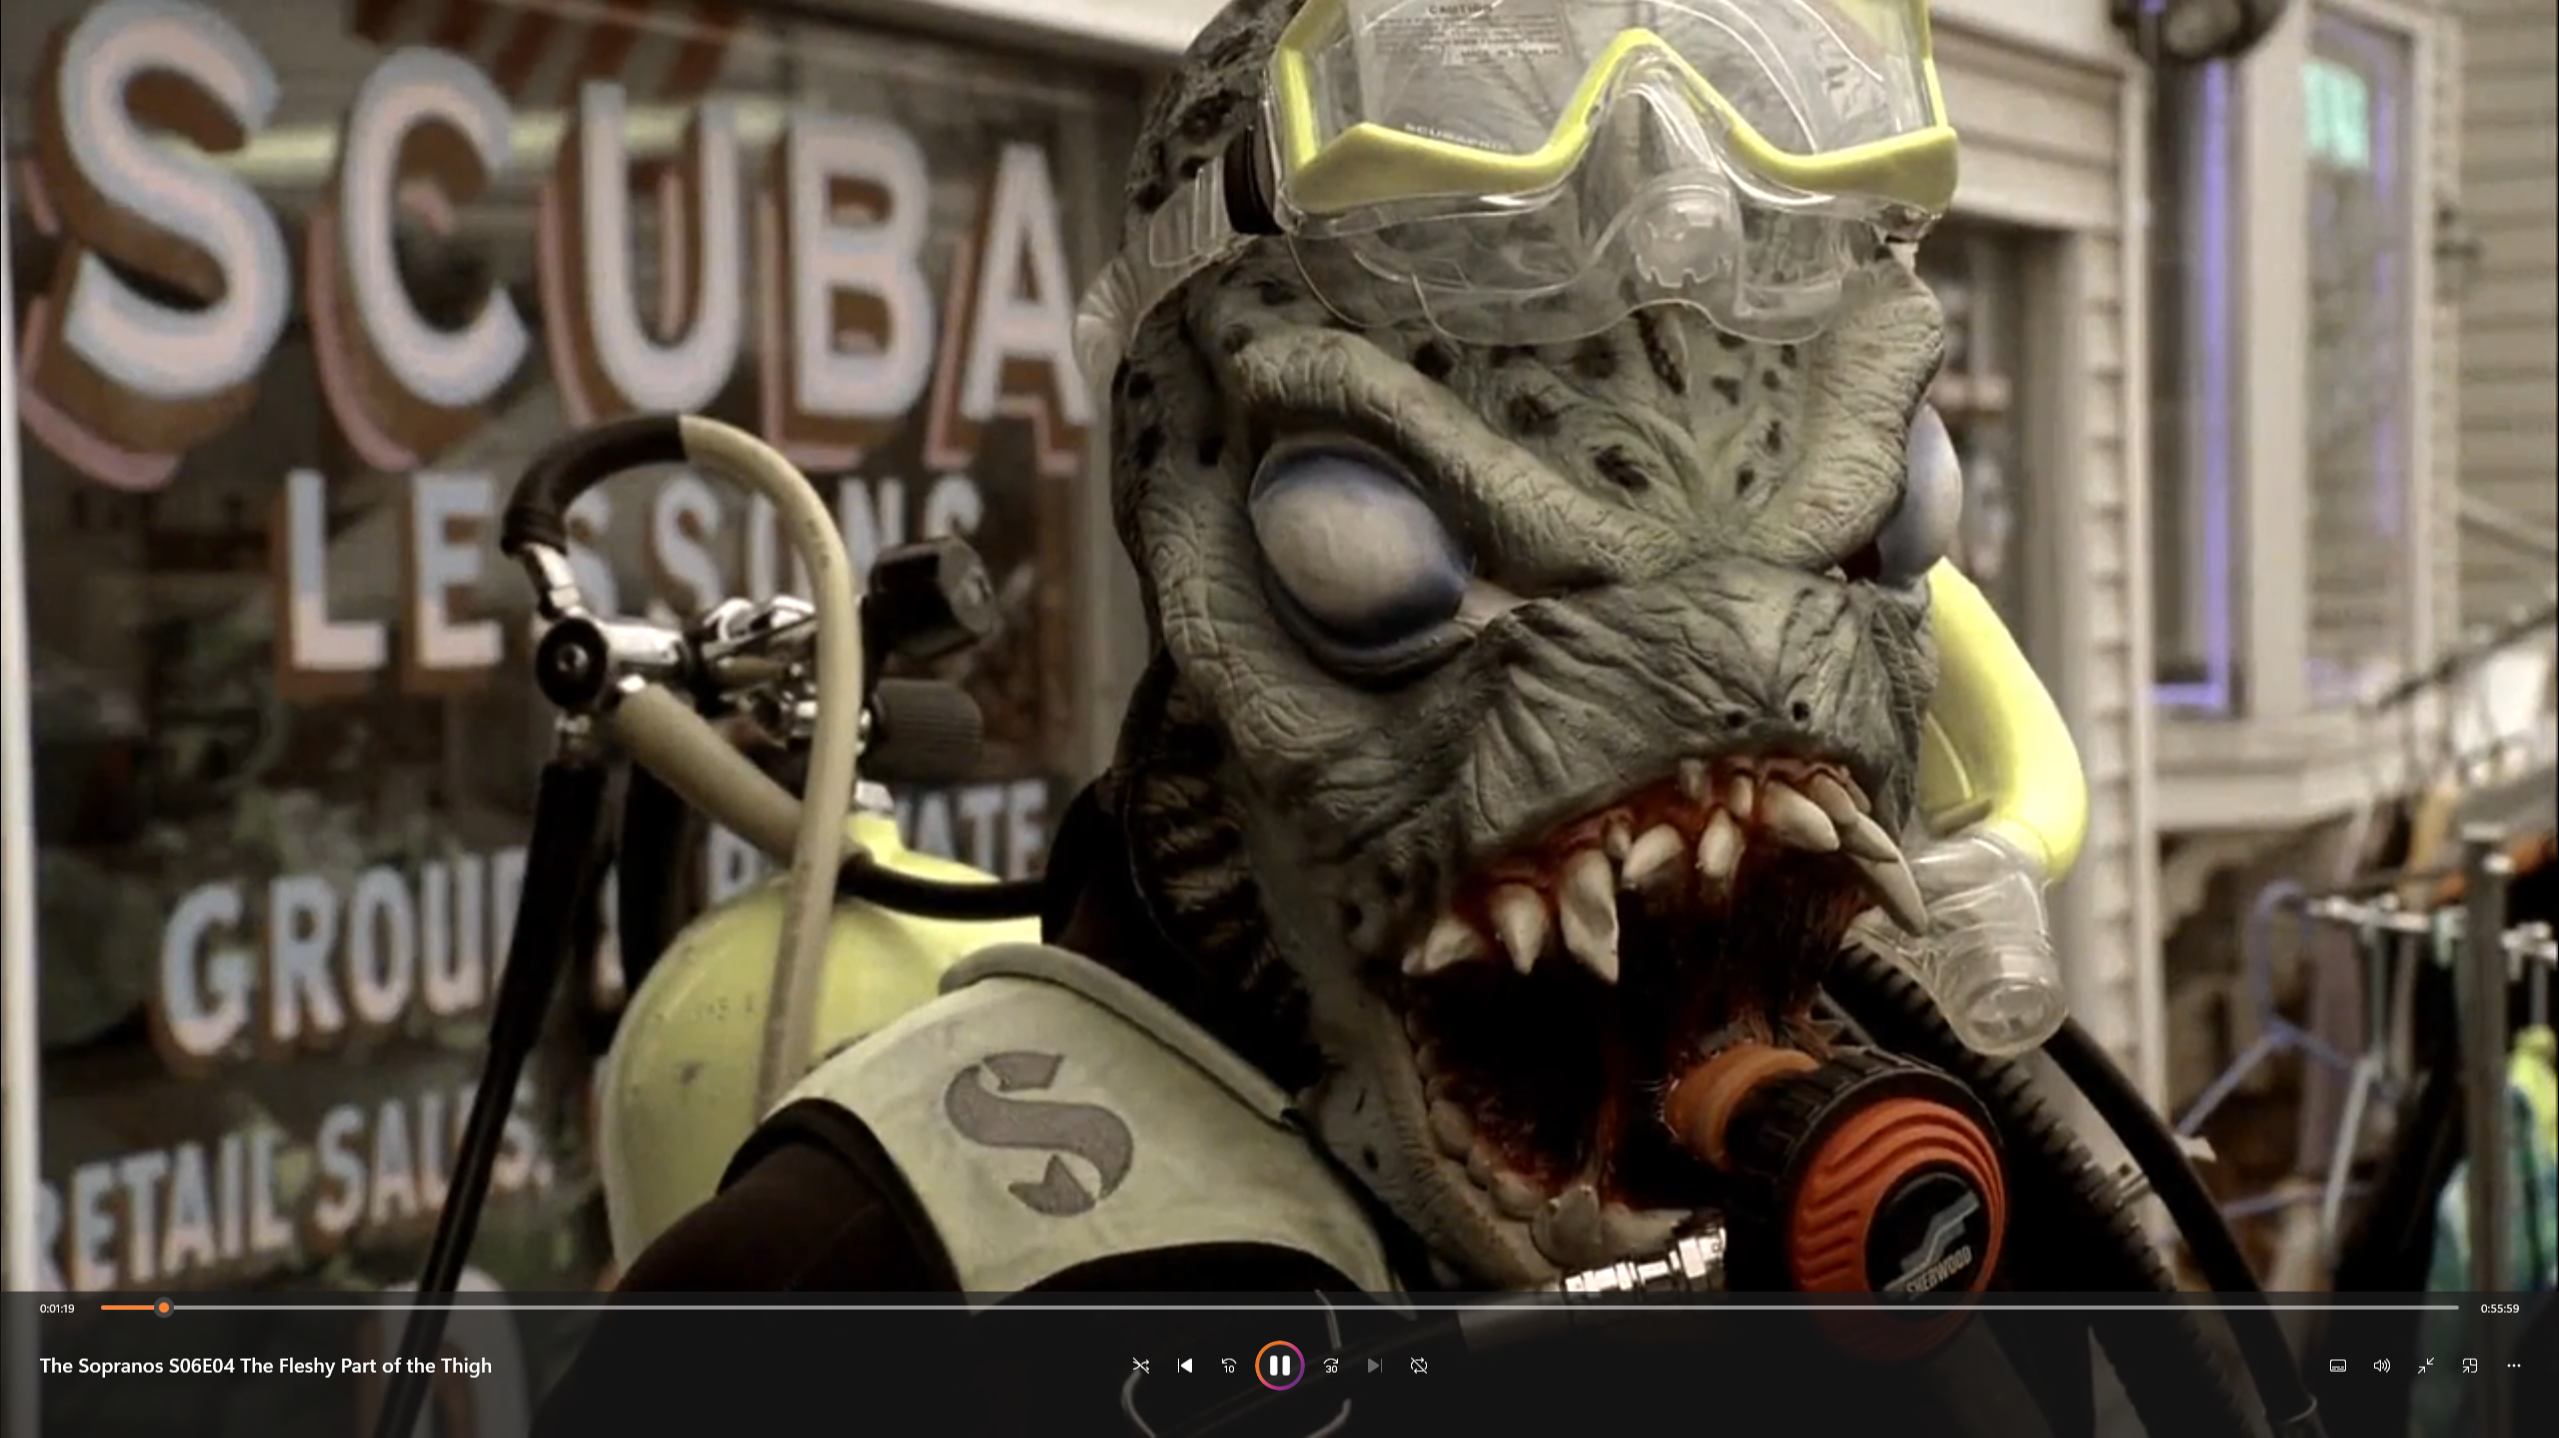

In [22]:
theimg